In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split

from models import model__prior_mu_studentT as model 
from collections import Counter


### Data Processing

In [2]:
scaler = StandardScaler()
df = pd.read_pickle('./pickle/df.pkl')

In [3]:
df_sampled = df.sample(1400,random_state=47)

In [4]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [5]:
df_features = scaler.fit_transform(df_features)

In [6]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/7)

df_train_features, df_val_features,df_train_target, df_val_target =  train_test_split(df_train_features,df_train_target,stratify=df_train_target,random_state=47, test_size=1/6)

In [7]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()
df_val_target = df_val_target.to_numpy()

In [8]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=4
tau=1

In [9]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Final Model training 

In [10]:
degF=4
tau=1

In [11]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 15000

learning_rates = [0.0001,0.001,0.01]
# Setup the optimizer
acc_val_lr = []
for lr in learning_rates:

    adam_params = {"lr": lr}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))

            #ef model(X, n_cat, degF, tau, obs=None):
    predictive = Predictive(model, guide=guide, num_samples=2000,
                    return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
            
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({lr:acc})
    acc_val_lr.append({lr:acc})

[0] ELBO: 4807.4
[1000] ELBO: 4063.4
[2000] ELBO: 3410.6
[3000] ELBO: 3023.7
[4000] ELBO: 2614.7
[5000] ELBO: 2444.0
[6000] ELBO: 2298.5
[7000] ELBO: 2160.4
[8000] ELBO: 2085.0
[9000] ELBO: 2004.2
[10000] ELBO: 1989.4
[11000] ELBO: 1955.3
[12000] ELBO: 1894.8
[13000] ELBO: 1867.9
[14000] ELBO: 1845.6


C:\Users\MNIS\AppData\Local\Temp\ipykernel_19968\1890058607.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  mean_alpha = mean_alpha.T


{0.0001: 0.45}
[0] ELBO: 1833.5
[1000] ELBO: 1689.7
[2000] ELBO: 1664.2
[3000] ELBO: 1654.2
[4000] ELBO: 1638.9
[5000] ELBO: 1639.7
[6000] ELBO: 1635.6
[7000] ELBO: 1629.7
[8000] ELBO: 1627.4
[9000] ELBO: 1631.1
[10000] ELBO: 1633.1
[11000] ELBO: 1625.9
[12000] ELBO: 1627.2
[13000] ELBO: 1624.0
[14000] ELBO: 1633.4
{0.001: 0.475}
[0] ELBO: 1627.1
[1000] ELBO: 1674.7
[2000] ELBO: 1671.7
[3000] ELBO: 1693.9
[4000] ELBO: 1678.1
[5000] ELBO: 1682.7
[6000] ELBO: 1692.0
[7000] ELBO: 1709.4
[8000] ELBO: 1674.5
[9000] ELBO: 1695.7
[10000] ELBO: 1704.5
[11000] ELBO: 1693.0
[12000] ELBO: 1697.9
[13000] ELBO: 1743.1
[14000] ELBO: 1689.2
{0.01: 0.46}


In [12]:
for p in acc_val_lr:

    lr = list(p.keys())[0]
    acc = list(p.values())[0]

    print(f'The accuracy value for learning rate {lr} is {acc}')

The accuracy value for learning rate 0.0001 is 0.45
The accuracy value for learning rate 0.001 is 0.475
The accuracy value for learning rate 0.01 is 0.46


### Model training for optimal learning rate of 0.001

In [18]:
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

        #ef model(X, n_cat, degF, tau, obs=None):
predictive = Predictive(model, guide=guide, num_samples=2000,
                return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)


samples_alpha = samples["alpha"].detach().squeeze()
samples_beta = samples["beta"].detach().squeeze()


mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T
mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T


y_val_pred = np.zeros((N_val,n_cat))

for n in range(N_val):

    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

    p =  softmax(probs)
    y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    
y_val_pred = y_val_pred[:,0]
        
acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
print(acc)


[0] ELBO: 1624.5
[1000] ELBO: 1630.8
[2000] ELBO: 1621.7
[3000] ELBO: 1627.2
[4000] ELBO: 1624.0
[5000] ELBO: 1612.5
[6000] ELBO: 1618.8
[7000] ELBO: 1620.0
[8000] ELBO: 1626.0
[9000] ELBO: 1625.7
[10000] ELBO: 1619.9
[11000] ELBO: 1622.8
[12000] ELBO: 1624.1
[13000] ELBO: 1619.7
[14000] ELBO: 1617.5
0.475


In [19]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

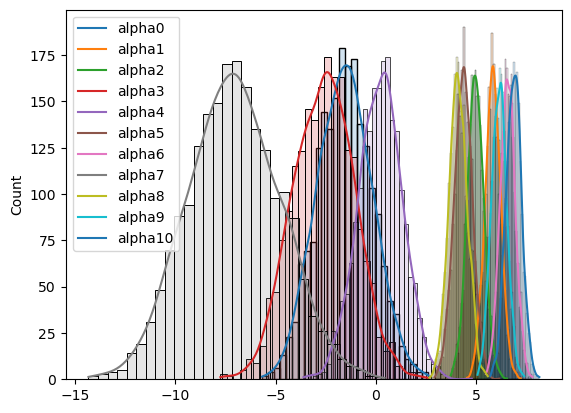

In [20]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

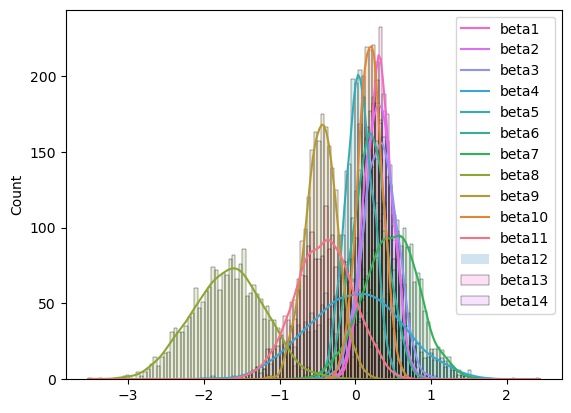

In [21]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [22]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

#### Computation of accuracy on the train set 

In [23]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [24]:
y_train_pred = y_train_pred[:,0]

In [25]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.507


#### Computation of accuracy on the test set 

In [26]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [27]:
y_test_pred = y_test_pred[:,0]

In [28]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.47
